In [40]:
#!pip install pyradiomics

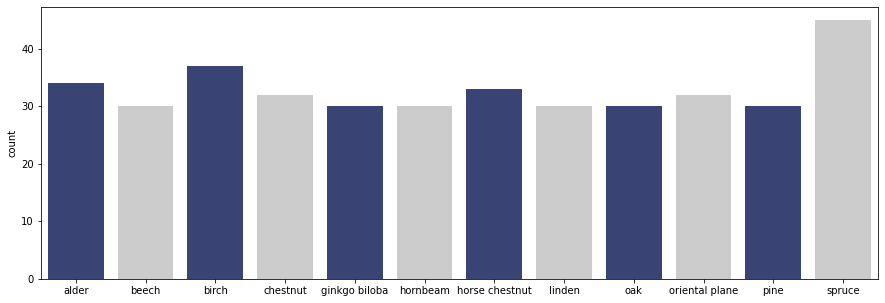

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Location of the dataset
data_dir = '../data/trunk12'
# Width and height of the cropped images
crop_s = 3000
# Width and height of the images after downsampling
new_s = 256
# Location where images are saved after processing
nii_dir = f'../data/trunk12_nii_{crop_s}_{new_s}'


# Read images from the dataset directory
dataset = torchvision.datasets.ImageFolder(root=data_dir)

# Show the number of images in each class
plt.figure(figsize=[15, 5])
p = sns.countplot(dataset.targets, palette=['#2F3C7E', '#CCCCCC'])
p.set_xticklabels(dataset.classes);
plt.savefig('../outputs/num_of_images_per_class.png', bbox_inches='tight', dpi=100)

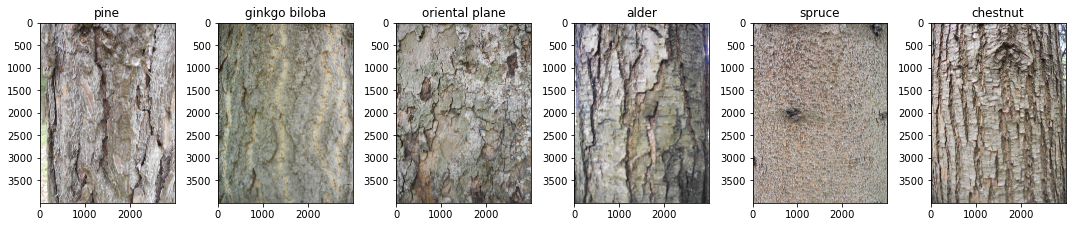

In [4]:
from PIL import Image
import random 
import torchvision.transforms as transforms

# Show multiple examples of images from the training set
n = 6
indices = random.sample(range(0, len(dataset.imgs)),n)
batch = [dataset.imgs[i] for i in indices]
trans = transforms.ToTensor()

plt.figure(figsize=[15,5])
for i in range(n):
    img = Image.open(batch[i][0])
    img = trans(img)
    img = torch.permute(img, (1,2,0))
    target = dataset.classes[batch[i][1]]
    plt.subplot(1,n,i+1)
    plt.imshow(img)
    plt.title(target)
plt.tight_layout()
plt.savefig('../outputs/image_examples_original.png', bbox_inches='tight', dpi=100)
plt.show()

In [7]:
import numpy as np
import nibabel as nib
from PIL import Image, ImageOps
import os

half_crop_s = int(crop_s/2)

for jpg_filename, label in dataset.imgs:

    # Open an image
    img = Image.open(jpg_filename)

    # Convert it to a grayscale image
    img = ImageOps.grayscale(img)
    w2 = int(img.size[0]/2)
    h2 = int(img.size[1]/2)

    # Down-sample the image
    img = img.crop((w2-half_crop_s, h2-half_crop_s, w2+half_crop_s, h2+half_crop_s))
    img = img.resize((new_s,new_s))

    # Increase contrast of the image
    extrema = img.getextrema()
    arr = np.asarray(img).astype('float')
    arr = (arr - extrema[0])/ (extrema[1] - extrema[0]) * 255

    # Write the images in nifti format
    arr = np.expand_dims(arr, axis=2)
    empty_header = nib.Nifti1Header()
    affine =  np.eye(4)
    another_img = nib.Nifti1Image(arr, affine, empty_header)
    nifti_filename = jpg_filename.replace(data_dir, nii_dir)
    nifti_filename = nifti_filename.replace('.JPG', '.nii.gz')
    path = nifti_filename.replace(nifti_filename.split('/')[-1], "")
    os.makedirs(path, exist_ok = True)
    nib.save(another_img, nifti_filename)

In [5]:
import nibabel as nib

# Show the new size of the image
img = nib.load(dataset.imgs[0][0].replace(data_dir, nii_dir).replace('.JPG', '.nii.gz'))
img.shape

(256, 256, 1)

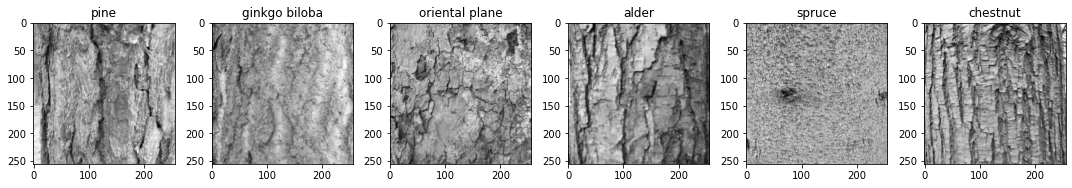

In [6]:
# Show multiple examples of images from the training set
plt.figure(figsize=[15,5])
for i in range(n):
    img = nib.load(batch[i][0].replace(data_dir, nii_dir).replace('.JPG', '.nii.gz'))
    img = np.array(img.dataobj)
    target = dataset.classes[batch[i][1]]
    plt.subplot(1,n,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(target)
plt.tight_layout()
plt.savefig('../outputs/image_examples_processed.png', bbox_inches='tight', dpi=100)
plt.show()

In [11]:
import numpy as np
from PIL import Image

# Save a default mask file in nifti format
mask = np.ones(img.shape) *255
mask[:1, :1, :] = 0
mask = mask.astype(np.uint8)
mask_filename = "../outputs/mask.nii.gz"
print(np.unique(np.asarray(mask)))

empty_header = nib.Nifti1Header()
affine = np.eye(4)
another_img = nib.Nifti1Image(mask, affine, empty_header)
print(another_img.header.get_data_shape())
nib.save(another_img, mask_filename)

[  0 255]
(256, 256, 1)


In [8]:
import csv
import numpy as np
import pandas as pd

# Write a csv file with location and label of each image in the train set
pyradiomics_header = ('Image','Mask', 'Label')
m_arr = [mask_filename] * len(dataset.imgs)
rows = [(il[0].replace(data_dir, nii_dir).replace('.JPG', '.nii.gz'), m, 255) for m, il in zip(m_arr, dataset.imgs)]
rows.insert(0, pyradiomics_header)
arr = np.asarray(rows)
np.savetxt('../outputs/pyradiomics_samples.csv', arr, fmt="%s", delimiter=",")
ds = pd.read_csv('../outputs/pyradiomics_samples.csv')
ds.head()


,Image,Mask,Label
0,../data/trunk12_nii_3000_256/alder/1.nii.gz,../outputs/mask.nii.gz,255
1,../data/trunk12_nii_3000_256/alder/10.nii.gz,../outputs/mask.nii.gz,255
2,../data/trunk12_nii_3000_256/alder/11.nii.gz,../outputs/mask.nii.gz,255
3,../data/trunk12_nii_3000_256/alder/12.nii.gz,../outputs/mask.nii.gz,255
4,../data/trunk12_nii_3000_256/alder/13.nii.gz,../outputs/mask.nii.gz,255


In [12]:
import radiomics
from radiomics import featureextractor 

print(dataset.imgs[0])
nifti_filename = dataset.imgs[0][0].replace(data_dir, nii_dir).replace('.JPG', '.nii.gz')
# Instantiate the radiomics feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor(force2D=True)
output = extractor.execute(nifti_filename, mask_filename, label=255)


('../data/trunk12/alder/1.JPG', 0)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [13]:
import six 

# Make an array of the values
names =  np.array([])
features = np.array([])
for key, value in six.iteritems(output):
    if key.startswith("original_"):
        names = np.append (names, key)
        features = np.append ( features, output[key])

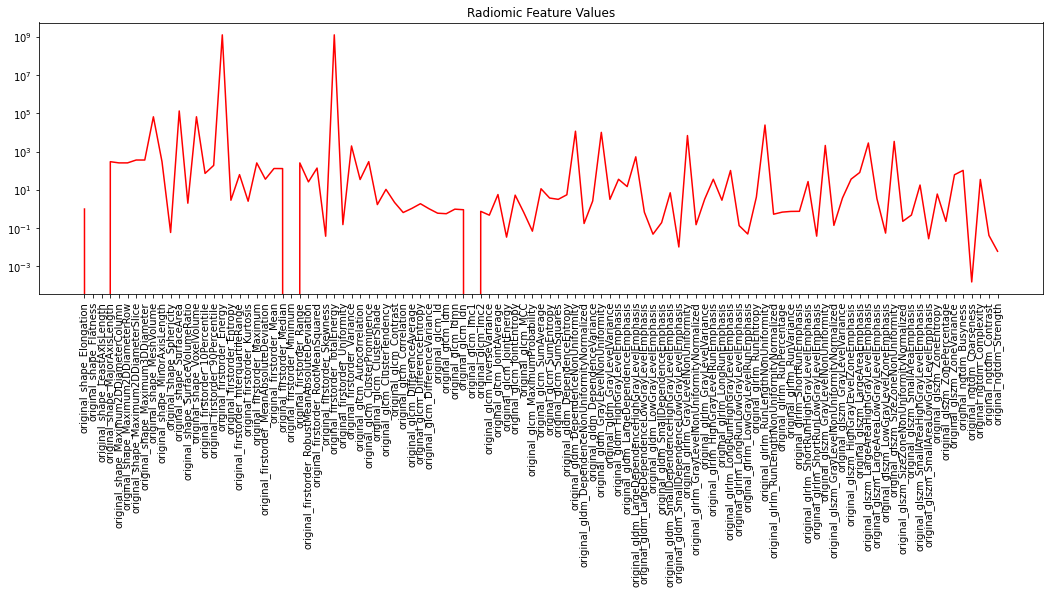

In [14]:
# Plot the feature  values
names_l = list(names)
fig, ax = plt.subplots(figsize=[18,5])
plt.plot(features, color='red')
plt.yscale('log')
plt.xticks(range(len(names_l)), names_l, rotation=90)
plt.title ( "Radiomic Feature Values");
plt.savefig('../outputs/example_radiomics.png', bbox_inches='tight', dpi=100)

In [61]:
# Run Pyradiomics on pyradiomics_sample.csv, output to pyradi_features.csv
!pyradiomics -o ../outputs/pyradi_features_{crop_s}_{new_s}.csv -f csv ../outputs/pyradiomics_samples.csv &> ../outputs/log.txt

4894.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [3]:
import pandas as pd

# Declare csv filename from Pyradiomics (zscore scaled and merged)
fname = f'../outputs/pyradi_features_{crop_s}_{new_s}.csv'

# Load data
pyradi_data = pd.read_csv(fname)
pyradi_data.shape

(393, 132)

In [4]:
# Define a style for the dataframe
def make_pretty(styler):
    styler.background_gradient(axis=None, cmap="viridis")
    return styler
    
# Show the radiomic feature columns
pyradi_original = pyradi_data.iloc[:,25:]
pyradi_original.head().style.pipe(make_pretty)

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.999955,0.000000,0.000000,295.603338,256.000000,256.000000,361.332257,361.332257,65279.416667,295.589911,0.059626,131492.133508,2.014297,65535.000000,87.786888,199.610657,1481500414.321158,2.798012,56.434433,2.834817,255.000000,33.662581,144.339015,146.311478,0.000000,255.000000,23.834549,150.353740,-0.277719,1481500414.321158,0.165234,1772.495954,41.868467,330.088794,-8.526698,10.758915,0.856679,0.852495,0.600958,1.389144,0.485491,0.736677,0.724642,0.993136,0.951494

In [5]:
# Show values of a GLDM feature column
pyradi_original['original_gldm_DependenceNonUniformity'].head()

0    8844.608057
1    9582.996674
2    9345.259464
3    9492.411398
4    9864.955322
Name: original_gldm_DependenceNonUniformity, dtype: float64

In [6]:
# Normalize the feature values
pyradi_original_norm = (pyradi_original - pyradi_original.min()) / (pyradi_original.max() - pyradi_original.min())

# Add the class labels
pyradi_original_norm['target'] = dataset.targets

In [7]:
# Define a style for the dataframe
def make_pretty(styler):
    styler.background_gradient(axis=None, cmap="viridis")
    return styler
# Show the values after normalization
pyradi_original_norm.head().style.pipe(make_pretty)

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,target
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.607064,0.686612,0.546635,0.656822,0.200482,0.406486,nan,0.271863,0.604532,0.600395,nan,nan,0.201819,0.617146,0.414493,0.546635,0.255134,0.200392,0.543776,0.126312,0.479659,0.198556,0.288863,0.751363,0.414432,0.520267,0.330095,0.490050,0.513885,0.699796,0.563232,0.497378,0.850885,0.725036,0.602305,0.176972,0.636752,0.739154,0.209996,0.602305,0.697510,0.206071,0.678510,0.120004,0.120004,0.472489,0.255134,0

In [8]:
# Get the class labels and drop the class column
Y = pyradi_original_norm['target']
pyradi_original_norm = pyradi_original_norm.drop('target', axis=1)
pyradi_original_norm.shape

(393, 107)

In [9]:
# Drop features will NaN values
pyradi_original_norm = pyradi_original_norm.dropna(axis=1, how='all')
pyradi_original_norm.shape

(393, 90)

In [10]:
# Show values of a GLDM feature column after normalization
pyradi_original_norm['original_gldm_DependenceNonUniformity'].head()

0    0.120004
1    0.218205
2    0.186587
3    0.206157
4    0.255703
Name: original_gldm_DependenceNonUniformity, dtype: float64

In [11]:
# Show the features with no NaN values
for col in pyradi_original_norm.columns:
    print(col)

original_firstorder_10Percentile
original_firstorder_90Percentile
original_firstorder_Energy
original_firstorder_Entropy
original_firstorder_InterquartileRange
original_firstorder_Kurtosis
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Mean
original_firstorder_Median
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_RootMeanSquared
original_firstorder_Skewness
original_firstorder_TotalEnergy
original_firstorder_Uniformity
original_firstorder_Variance
original_glcm_Autocorrelation
original_glcm_ClusterProminence
original_glcm_ClusterShade
original_glcm_ClusterTendency
original_glcm_Contrast
original_glcm_Correlation
original_glcm_DifferenceAverage
original_glcm_DifferenceEntropy
original_glcm_DifferenceVariance
original_glcm_Id
original_glcm_Idm
original_glcm_Idmn
original_glcm_Idn
original_glcm_Imc1
original_glcm_Imc2
original_glcm_InverseVariance
original_glcm_JointAverage
original_glcm_JointEnergy
original_glcm_JointEntropy
original_glcm_MCC
original_

In [34]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
import statistics
from sklearn.metrics import matthews_corrcoef

# Function to evaluate a classification model using KFold cross validation
def evaluate_model(model, df, y, calc_auc=False):
    auc_lr=[]
    pre_lr=[]
    rec_lr=[]
    acc_lr=[]
    f1_lr=[]
    auc_lrt=[]
    pre_lrt=[]
    rec_lrt=[]
    acc_lrt=[]
    f1_lrt=[]

    cv = StratifiedKFold(n_splits=7,  shuffle=False)
    for train_index, test_index in cv.split(df, y):
       
       # Get a certain fold
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        Y_train, Y_test= y.iloc[train_index], y.iloc[test_index]

        X_train= X_train.values
        X_test= X_test.values
        Y_train= Y_train.values
        Y_test= Y_test.values

        clf = make_pipeline(model)
        clf.fit(X_train, Y_train)

        # Get predictions and measure evaluation metrics
        pred = clf.predict(X_test)
        pre_l = precision_score(Y_test, pred, average='weighted')
        rec_l = recall_score(Y_test, pred, average='weighted')
        acc_l = accuracy_score(Y_test, pred)
        if calc_auc:
            probs = clf.predict_proba(X_test)
            auc_l = roc_auc_score(Y_test, probs, average='weighted', multi_class='ovr')

        f1_l = f1_score(Y_test, pred, average='weighted')

        pred = clf.predict(X_train)
        pre_lt = precision_score(Y_train, pred, average='weighted')
        rec_lt = recall_score(Y_train, pred, average='weighted')
        acc_lt = accuracy_score(Y_train, pred)
        if calc_auc:
            probs = clf.predict_proba(X_train)
            auc_lt = roc_auc_score(Y_train, probs, average='weighted', multi_class='ovr')
        f1_lt = f1_score(Y_train, pred, average='weighted')

        # Keep the evaluation metric values for each fold
        if calc_auc: auc_lr.append(auc_l)
        pre_lr.append(pre_l)
        rec_lr.append(rec_l)
        acc_lr.append(acc_l)
        f1_lr.append(f1_l)

        if calc_auc: auc_lrt.append(auc_lt)
        pre_lrt.append(pre_lt)
        rec_lrt.append(rec_lt)
        acc_lrt.append(acc_lt)
        f1_lrt.append(f1_lt)

    # Measure the average of the evaluation metrics for all the folds
    avg_auc_lrt = -1
    avg_pre_lrt = statistics.mean(pre_lrt)
    avg_rec_lrt = statistics.mean(rec_lrt)
    avg_acc_lrt = statistics.mean(acc_lrt)
    if calc_auc: avg_auc_lrt = statistics.mean(auc_lrt)
    avg_f1_lrt = statistics.mean(f1_lrt)

    avg_auc_lr = -1
    avg_pre_lr = statistics.mean(pre_lr)
    avg_rec_lr = statistics.mean(rec_lr)
    avg_acc_lr = statistics.mean(acc_lr)
    if calc_auc: avg_auc_lr = statistics.mean(auc_lr)
    avg_f1_lr = statistics.mean(f1_lr)

    return avg_pre_lrt, avg_rec_lrt, avg_acc_lrt, avg_auc_lrt, avg_f1_lrt, avg_pre_lr, avg_rec_lr, avg_acc_lr, avg_auc_lr, avg_f1_lr

In [45]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import numpy as np

def precision_recall(model, df, y, model_name):

    y=np.array(y)
    n_classes = len(set(y))
    thresholds = list(np.arange(0,1,0.1))
    y_bin = label_binarize(y, classes=[*range(n_classes)])

    X_train, X_test, Y_train, Y_test = train_test_split(df, y_bin, test_size=60, random_state = 42)

    clf =  OneVsRestClassifier(model)
    clf.fit(X_train, Y_train)
    y_score = clf.predict_proba(X_test)

    precision = dict()
    recall = dict()
    average_precision = dict()
    average_recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
    
    plt.figure(figsize=(4,4))
    plt.plot(recall["micro"], precision["micro"], 'ro-', markersize=5, lw=2, fillstyle='none')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid(True, linestyle='--', linewidth=1)
    plt.title('Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))
    plt.savefig(f'../outputs/prec_recall_{model_name}_crop_s_{crop_s}_new_s_{new_s}.png', bbox_inches='tight', dpi=100)
    plt.show()


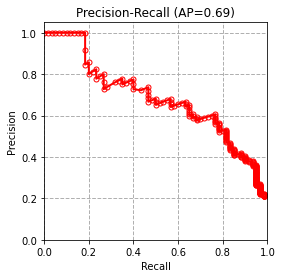

---------------TRAIN---------------
PRE:	 1.00
REC:	 1.00
ACC:	 1.00
AUC:	 1.00
F1:	 1.00
---------------TEST---------------
PRE:	 0.66
REC:	 0.66
ACC:	 0.66
AUC:	 0.94
F1:	 0.64


In [46]:
from xgboost import XGBClassifier

# Evaluate XGBoost classifier
calc_auc = True
model = XGBClassifier(n_estimators=1000, max_depth=1, learning_rate=0.5, min_child_weight=5)
precision_recall(model, pyradi_original_norm, Y, 'xgboost')
stats_xgb = evaluate_model(model, pyradi_original_norm, Y, calc_auc)

print("---------------TRAIN---------------")
print("PRE:\t %.02f"% stats_xgb[0])
print("REC:\t %.02f"% stats_xgb[1])
print("ACC:\t %.02f"% stats_xgb[2])
if calc_auc: print("AUC:\t %.02f"%stats_xgb[3])
print("F1:\t %.02f"% stats_xgb[4])

print("---------------TEST---------------")
print("PRE:\t %.02f"% stats_xgb[5])
print("REC:\t %.02f"% stats_xgb[6])
print("ACC:\t %.02f"% stats_xgb[7])
if calc_auc: print("AUC:\t %.02f"% stats_xgb[8])
print("F1:\t %.02f"% stats_xgb[9])

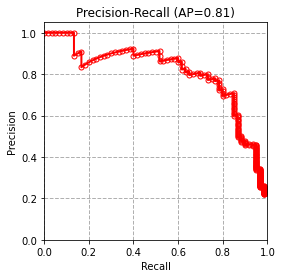

---------------TRAIN---------------
PRE:	 0.92
REC:	 0.91
ACC:	 0.91
AUC:	 0.99
F1:	 0.91
---------------TEST---------------
PRE:	 0.70
REC:	 0.70
ACC:	 0.70
AUC:	 0.95
F1:	 0.68


In [47]:
from sklearn.svm import SVC

# Evaluate SVM classifier
calc_auc = True
model = SVC(kernel='poly', degree=4, probability=True)
precision_recall(model, pyradi_original_norm, Y, 'svm')
stats_svc = evaluate_model(model, pyradi_original_norm, Y, calc_auc)

print("---------------TRAIN---------------")
print("PRE:\t %.02f"% stats_svc[0])
print("REC:\t %.02f"% stats_svc[1])
print("ACC:\t %.02f"% stats_svc[2])
if calc_auc: print("AUC:\t %.02f"% stats_svc[3])
print("F1:\t %.02f"% stats_svc[4])

print("---------------TEST---------------")
print("PRE:\t %.02f"% stats_svc[5])
print("REC:\t %.02f"% stats_svc[6])
print("ACC:\t %.02f"% stats_svc[7])
if calc_auc: print("AUC:\t %.02f"% stats_svc[8])
print("F1:\t %.02f"% stats_svc[9])



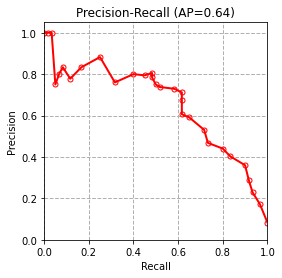

---------------TRAIN---------------
PRE:	 1.00
REC:	 1.00
ACC:	 1.00
AUC:	 1.00
F1:	 1.00
---------------TEST---------------
PRE:	 0.63
REC:	 0.62
ACC:	 0.62
AUC:	 0.91
F1:	 0.60


In [49]:
from sklearn.ensemble import RandomForestClassifier

# Evaluate Random Forest Classifier
calc_auc = True
model = RandomForestClassifier(max_samples=0.8, n_estimators=30)
precision_recall(model, pyradi_original_norm, Y, 'rf')
stats_rf = evaluate_model(model, pyradi_original_norm, Y, calc_auc)

print("---------------TRAIN---------------")
print("PRE:\t %.02f"% stats_rf[0])
print("REC:\t %.02f"% stats_rf[1])
print("ACC:\t %.02f"% stats_rf[2])
if calc_auc: print("AUC:\t %.02f"% stats_rf[3])
print("F1:\t %.02f"% stats_rf[4])

print("---------------TEST---------------")
print("PRE:\t %.02f"% stats_rf[5])
print("REC:\t %.02f"% stats_rf[6])
print("ACC:\t %.02f"% stats_rf[7])
if calc_auc: print("AUC:\t %.02f"% stats_rf[8])
print("F1:\t %.02f"% stats_rf[9])


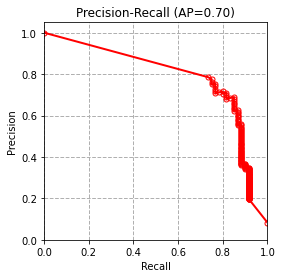

---------------TRAIN---------------
PRE:	 1.00
REC:	 1.00
ACC:	 1.00
AUC:	 1.00
F1:	 1.00
---------------TEST---------------
PRE:	 0.68
REC:	 0.68
ACC:	 0.68
AUC:	 0.95
F1:	 0.66


In [50]:
from sklearn.linear_model import LogisticRegression
  
# Evaluate Logistic Regression Model
calc_auc = True
model = LogisticRegression(max_iter=10000, penalty='none')
precision_recall(model, pyradi_original_norm, Y, 'lr')
stats_lr = evaluate_model(model, pyradi_original_norm, Y, calc_auc)

print("---------------TRAIN---------------")
print("PRE:\t %.02f"% stats_lr[0])
print("REC:\t %.02f"% stats_lr[1])
print("ACC:\t %.02f"% stats_lr[2])
if calc_auc: print("AUC:\t %.02f"% stats_lr[3])
print("F1:\t %.02f"% stats_lr[4])

print("---------------TEST---------------")
print("PRE:\t %.02f"% stats_lr[5])
print("REC:\t %.02f"% stats_lr[6])
print("ACC:\t %.02f"% stats_lr[7])
if calc_auc: print("AUC:\t %.02f"% stats_lr[8])
print("F1:\t %.02f"% stats_lr[9])


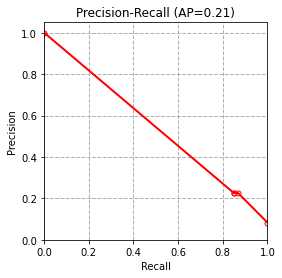

---------------TRAIN---------------
PRE:	 0.60
REC:	 0.52
ACC:	 0.52
AUC:	 0.80
F1:	 0.48
---------------TEST---------------
PRE:	 0.47
REC:	 0.46
ACC:	 0.46
AUC:	 0.75
F1:	 0.40


In [68]:
from sklearn.linear_model import SGDClassifier

# Evaluate SGD classifier
calc_auc = True
model = SGDClassifier(loss='modified_huber',class_weight='balanced')
precision_recall(model, pyradi_original_norm, Y, 'sgd')
stats_sgd = evaluate_model(model, pyradi_original_norm, Y, calc_auc)

print("---------------TRAIN---------------")
print("PRE:\t %.02f"% stats_sgd[0])
print("REC:\t %.02f"% stats_sgd[1])
print("ACC:\t %.02f"% stats_sgd[2])
if calc_auc: print("AUC:\t %.02f"% stats_sgd[3])
print("F1:\t %.02f"% stats_sgd[4])

print("---------------TEST---------------")
print("PRE:\t %.02f"% stats_sgd[5])
print("REC:\t %.02f"% stats_sgd[6])
print("ACC:\t %.02f"% stats_sgd[7])
if calc_auc: print("AUC:\t %.02f"% stats_sgd[8])
print("F1:\t %.02f"% stats_sgd[9])    

In [69]:
stats_xgb = list(stats_xgb)
stats_svc = list(stats_svc)
stats_rf = list(stats_rf)
stats_lr = list(stats_lr)
stats_sgd = list(stats_sgd)

In [70]:
from itertools import zip_longest
import csv

# Save the performance of all the evaluated models in a csv file
names = ['PRE_train', 'REC_train', 'ACC_train', 'AUC_train', 'F1_train', 
         'PRE_test', 'REC_test', 'ACC_test', 'AUC_test', 'F1_test']
rows = [names, stats_xgb, stats_svc, stats_rf, stats_lr, stats_sgd]
export_data = zip_longest(*rows, fillvalue = '')
filename = f'../outputs/stats_crop_s_{crop_s}_new_s_{new_s}.csv'
with open(filename, 'w', encoding="ISO-8859-1", newline='') as f:
      wr = csv.writer(f)
      wr.writerow(("Classifier", "XGBoost", "SVM", "RandomForest", "LinearRegression", "SGD"))
      wr.writerows(export_data)
f.close()

def make_pretty(styler):
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="viridis")
    return styler

pd.set_option("display.precision", 3)
df = pd.read_csv(filename)
df.style.pipe(make_pretty)

,Classifier,XGBoost,SVM,RandomForest,LinearRegression,SGD
0,PRE_train,1.000,0.916,0.996,1.000,0.604
1,REC_train,1.000,0.913,0.996,1.000,0.524
2,ACC_train,1.000,0.913,0.996,1.000,0.524
3,AUC_train,1.000,0.994,1.000,1.000,0.801
4,F1_train,1.000,0.912,0.996,1.000,0.481
5,PRE_test,0.660,0.703,0.631,0.680,0.468
6,REC_test,0.656,0.699,0.618,0.679,0.460
7,ACC_test,0.656,0.699,0.618,0.679,0.460
8,AUC_test,0.935,0.954,0.911,0.950,0.751
9,F1_test,0.638,0.682,0.596,0.663,0.402


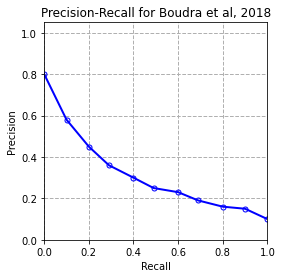

In [117]:
# Precision-Recall plot by Boudra et al, 2018
precision = [0.8, 0.58, 0.45, 0.36, 0.3, 0.25, 0.23, 0.19, 0.16, 0.15, 0.1]
recall = [0, 0.1, 0.2, 0.29, 0.4, 0.49, 0.6, 0.69, 0.8, 0.9, 1.0]

plt.figure(figsize=(4,4))
plt.plot(recall, precision, 'bo-', markersize=5, lw=2, fillstyle='none')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True, linestyle='--', linewidth=1)
plt.title('Precision-Recall for Boudra et al, 2018')
plt.savefig(f'../outputs/prec_recall_boudra.png', bbox_inches='tight', dpi=100)
plt.show()